In [8]:
#hide
#default_exp visualization.experiment_visualization
from nbdev.showdoc import *
from dsblocks.utils.nbdev_utils import nbdev_setup, TestRunner

nbdev_setup ()
tst = TestRunner (targets=['dummy'])

# Visualization utils

## Plot history

In [9]:
#export
import numpy as np
#import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
from IPython.display import display
import visdom
from hpsearch.config.hpconfig import get_path_results, get_path_experiments
import hpsearch.utils.experiment_utils as ut
from hpsearch.visualization import plot_utils 
import warnings
warnings.filterwarnings('ignore')

In [10]:
#for tests
import pytest
from dsblocks.utils.nbdev_utils import md
from hpsearch.examples.dummy_experiment_manager import generate_data
from hpsearch.examples.dummy_experiment_manager import run_multiple_experiments

In [11]:
#export           
def plot_multiple_histories (experiments, run_number=0, root_path=None, root_folder=None, metrics='all', 
                             metrics_second=[], parameters = None, compare = True, 
                             ylegend=0.5, name_file='model_history.pk', 
                             op='max', include_parameters_in_legend=False,
                             backend='visdom', **kwargs):
    
    if root_path is None:
        root_path = get_path_experiments(folder=root_folder)
    
    df = pd.read_csv('%s/experiments_data.csv' %root_path,index_col=0)
    df = ut.replace_with_default_values (df)
    df2 = ut.get_experiment_parameters (df.loc[experiments], only_not_null=True)
    parameters2, df2 = ut.get_parameters_unique(df2)

    if compare or parameters is not None:        
        if parameters is None:
            parameters = parameters2 
        df = df.loc[experiments,parameters]
    
    if type(metrics)==str and (metrics == 'all'):
        path_results = get_path_results (experiments[0], run_number=run_number, root_path=root_path)
        history = pickle.load(open('%s/%s' %(path_results, name_file),'rb'))
        metrics = history.keys()
    if type(metrics) == str:
        metrics = [metrics]
    if type(metrics_second) == str:
        metrics_second = [metrics_second]
    
    df_show = df.copy()
    
    for (imetric,metric) in enumerate(metrics):
        if imetric==0 and len(metrics_second)>0:
            title = ''
        else:
            title = metric
        traces = []
        for experiment_id in experiments:
            path_results = get_path_results (experiment_id, run_number=run_number, root_path=root_path)
            if os.path.exists('%s/%s' %(path_results, name_file)):
                history = pickle.load(open('%s/%s' %(path_results, name_file),'rb'))
                #values = [float(x) for x in history[metric]]
                if compare and include_parameters_in_legend:
                    label = '{}-{}'.format(experiment_id, list(dict(df.loc[experiment_id]).values()))
                else:
                    if (imetric==0) and (len(metrics_second)>0):
                        label = f'{experiment_id} ({metric})'
                    else:
                        label = f'{experiment_id}'
                traces = plot_utils.add_trace (history[metric], style='A.-', label=label, backend=backend, traces=traces)
                
                
                if op == 'min':
                    imin = int(np.array(history[metric]).argmin())
                else:
                    imin = int(np.array(history[metric]).argmax())
                vmin = float(history[metric][imin])
                traces = plot_utils.add_trace ([imin], [vmin], style='A.', label=None, backend=backend, 
                                               marker={'color': 'red', 'symbol': 104, 'size': 10},
                                               traces=traces)

                if (imetric==0) and (len(metrics_second)>0):
                    title += f' [{experiment_id} ({metric}): {vmin}]'
                else:
                    title += f' [{experiment_id}]: {vmin}'
                df_show.loc[experiment_id, metric] = vmin
                df2.loc[experiment_id, metric] = vmin
                
                if (imetric == 0):
                    for metric_second in metrics_second:
                        #values = [float(x) for x in history[metric_second]]
                        if compare and include_parameters_in_legend:
                            label = '{}: {}-{}'.format(metric_second, experiment_id, list(dict(df.loc[experiment_id]).values()))
                        else:
                            label = f'{experiment_id} ({metric_second})'
                        traces = plot_utils.add_trace (history[metric_second], style='A.-', label=label, backend=backend, traces=traces)
                        
                        if op == 'min':
                            imin = int(np.array(history[metric_second]).argmin())
                        else:
                            imin = int(np.array(history[metric_second]).argmax())
                        vmin = float(history[metric_second][imin])
                        traces = plot_utils.add_trace ([imin], [vmin], style='A.', label=None, backend=backend, 
                                                   marker={'color': 'red', 'symbol': 104, 'size': 10},
                                                   traces=traces)
                        title += f' [{experiment_id} ({metric_second}): {vmin}]'
                        df_show.loc[experiment_id, metric_second] = vmin
                        df2.loc[experiment_id, metric_second] = vmin

        plot_utils.plot(title=title, xlabel='epoch', ylabel=metric, traces=traces, backend=backend)
        if backend=='visdom':
            vis = visdom.Visdom()
            vis.text (df_show.to_html(justify='left', col_space=100), win= f'{metric}_parameters')
        display(df2)

In [12]:
#exports tests.visualization.test_experiment_visualization
def generate_data_plot (folder):
    em = generate_data (folder)
    run_multiple_experiments (em=em, nruns=5, noise=0.1, rate=0.1, verbose=False)
    
    return em

### usage

In [13]:
#exports tests.visualization.test_experiment_visualization
def test_plot_history ():
    em = generate_data_plot ('plot_history')
    
    md ('Plot all the metrics that have been stored in model_history')
    plot_multiple_histories ([8,16], run_number=0, op='max', backend='matplotlib')
    
    md ('Plot only one metric, and three experiments')
    md ('We plot the test_accuracy metric')
    plot_multiple_histories ([8,12, 16], run_number=0, op='max', metrics = 'test_accuracy', backend='matplotlib')
    
    md ('Use plotly as backend')
    plot_multiple_histories ([8,12, 16], run_number=0, op='max', metrics = 'test_accuracy', backend='plotly')
    
    em.remove_previous_experiments()

running test_plot_history


Plot all the metrics that have been stored in model_history

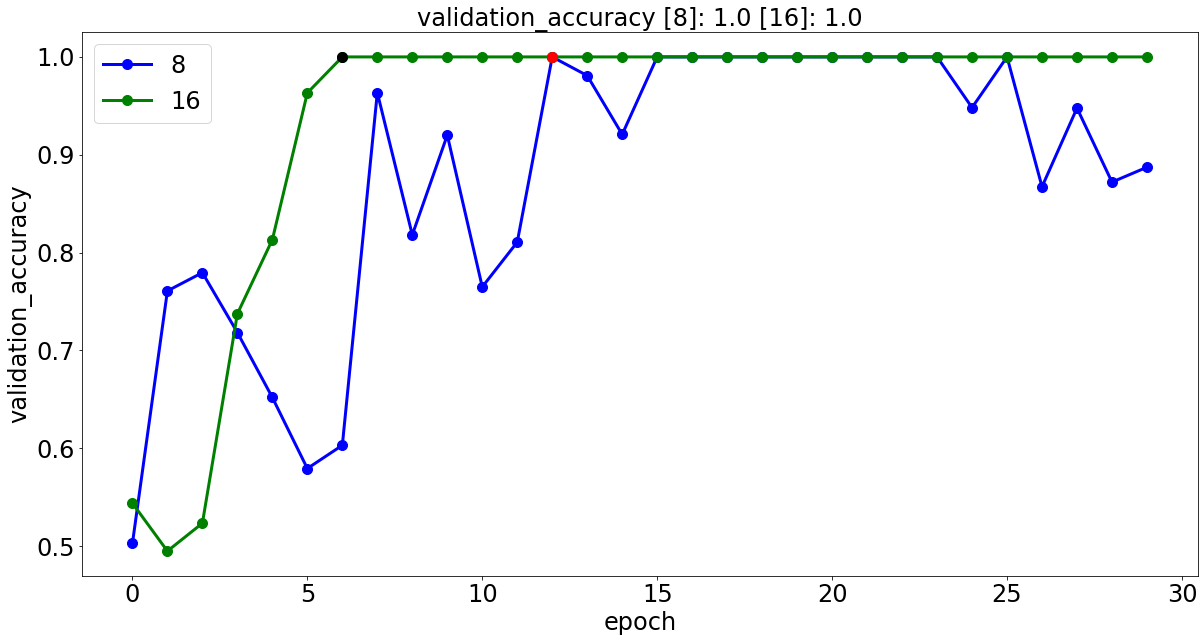

,offset,rate,validation_accuracy
8,0.6,0.03,1.0
16,0.3,0.10,1.0


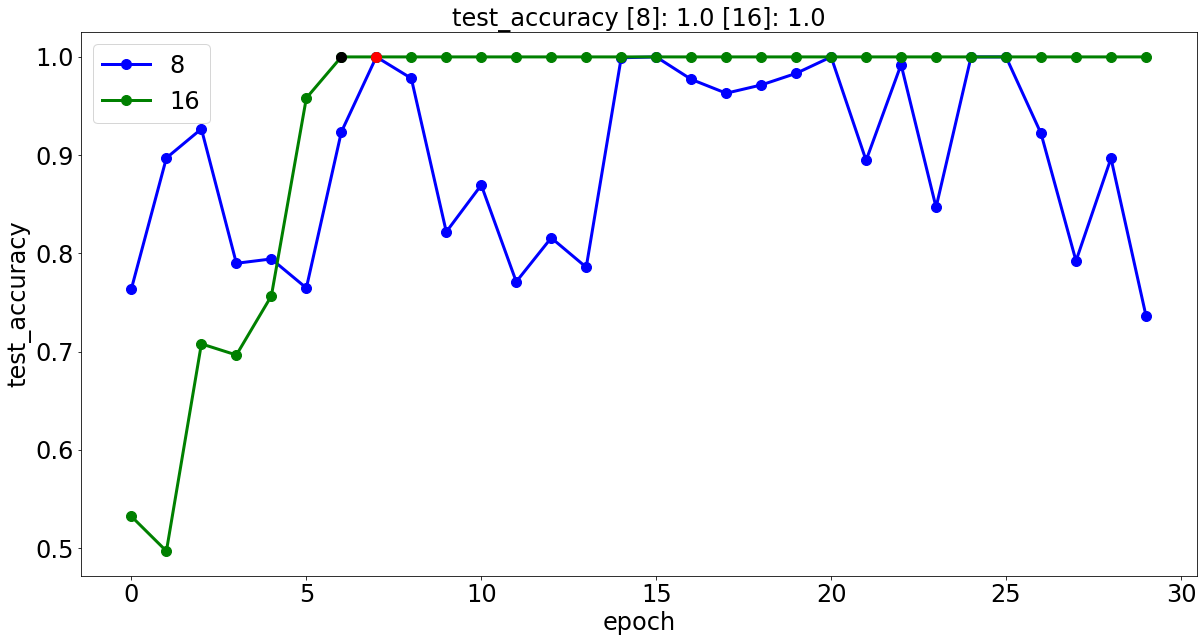

,offset,rate,validation_accuracy,test_accuracy
8,0.6,0.03,1.0,1.0
16,0.3,0.10,1.0,1.0


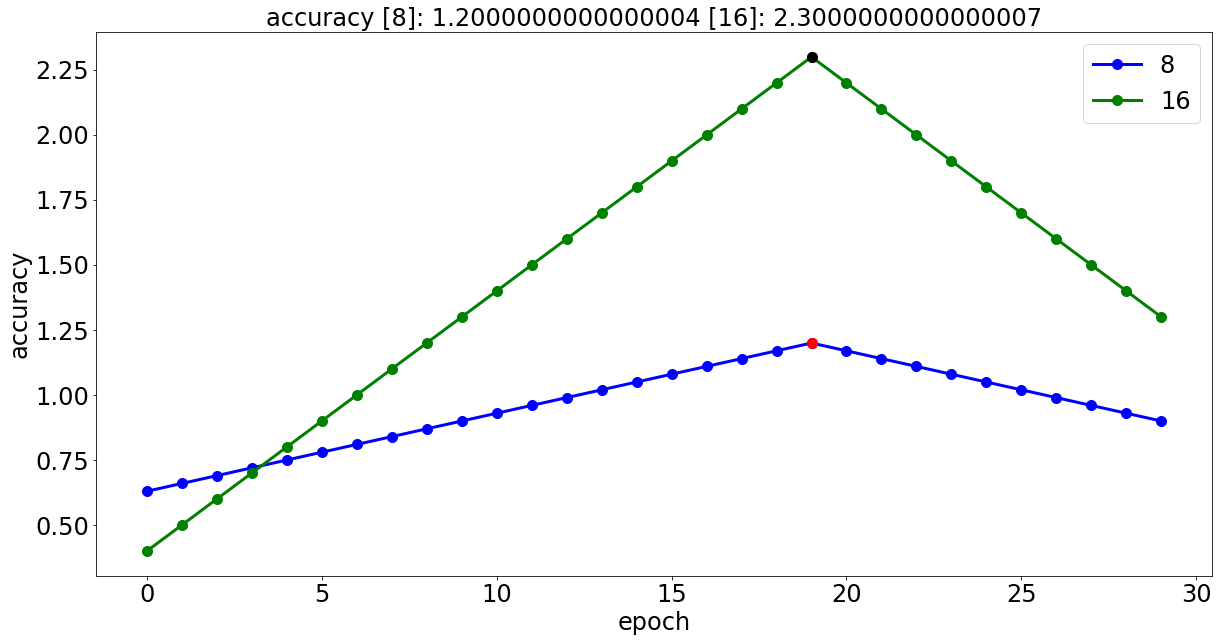

,offset,rate,validation_accuracy,test_accuracy,accuracy
8,0.6,0.03,1.0,1.0,1.2
16,0.3,0.10,1.0,1.0,2.3


Plot only one metric, and three experiments

We plot the test_accuracy metric

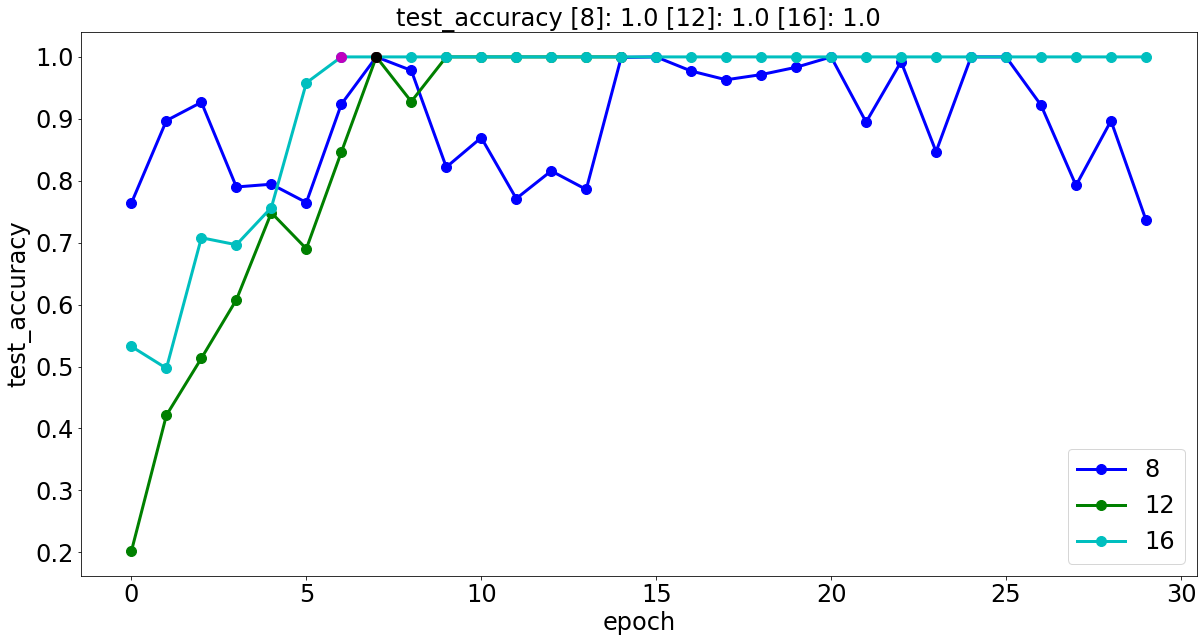

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


Use plotly as backend

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


In [14]:
tst.run (test_plot_history, tag='dummy')

## Metric correlation

Displays the relationship between scores obtained across experiments with two different evaluation metrics indicated as argument. Calculates Pearson R-squared coefficient.

In [15]:
#export
def plot_metric_relationship (metric_1, metric_2, folder_experiments=None, run_numbers=None, 
                              experiments=None, experiment_subset=None,
                              backend='visdom', **kwargs):
    df = ut.get_experiment_data (folder_experiments=folder_experiments, experiments=experiments)
    df_metric_1 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
    df_metric_2 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
    
    traces=plot_utils.add_trace(df_metric_1.values, df_metric_2.values, traces=[], style='A.', label='all experiments', backend=backend);
    
    if experiment_subset is not None:
        df_metric_1_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
        df_metric_2_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
        traces=plot_utils.add_trace(df_metric_1_subset.values, df_metric_2_subset.values, traces=traces, style='A.', label=f'selected subset', backend=backend);
    
    plot_utils.plot(np.linspace(df_metric_1.values.min(), df_metric_1.values.max(), 100), 
                np.linspace(df_metric_2.values.min(), df_metric_2.values.max(), 100), 
                traces=traces, style='A-', label='linear', title=f'{metric_1} vs {metric_2}', xlabel=metric_1, ylabel=metric_2, backend=backend);

### usage

In [16]:
#exports tests.visualization.test_experiment_visualization
def test_plot_metric_relationship ():
    em = generate_data_plot ('plot_metric_relationship')
    
    md ('plot relationship between validation and accuracy metrics')
    plot_metric_relationship ('validation_accuracy', 'test_accuracy', backend='plotly')

    md ('Highlight selected experiments')
    plot_metric_relationship ('validation_accuracy', 'test_accuracy', experiment_subset=[5,2], backend='plotly')
    
    em.remove_previous_experiments()

In [17]:
tst.run (test_plot_metric_relationship, tag='dummy')

running test_plot_metric_relationship


plot relationship between validation and accuracy metrics

Highlight selected experiments

## visualize_experiments

Main experiment visualization entry function

In [18]:
#export
## Generic Visualization
def visualize_experiments (visualization='history', **kwargs):
    if type(visualization) is str:
        visualization_list = [visualization]
    else:
        visualization_list = visualization
    for visualization in visualization_list:
        parameters = kwargs.copy()
        if visualization == 'history':
            assert 'experiments' in kwargs.keys(), 'experiments parameter expected when visualization is "history"'
            experiments = parameters.pop('experiments')
            plot_multiple_histories (experiments, **parameters)
        elif visualization == 'metric_correlation':
            assert 'metric_1' in kwargs.keys(), 'metric_1 parameter expected when visualization is "metric_correlation"'
            assert 'metric_2' in kwargs.keys(), 'metric_2 parameter expected when visualization is "metric_correlation"'
            metric_1 = parameters.pop('metric_1')
            metric_2 = parameters.pop('metric_2')
            plot_metric_relationship (metric_1, metric_2, **parameters)
        else:
            from hpsearch.config.hpconfig import experiment_visualization

            experiment_visualization (visualization=visualization, **kwargs)

### usage

In [19]:
#exports tests.visualization.test_experiment_visualization
def test_visualize_experiments ():
    em = generate_data_plot ('visualize_experiments')
    
    visualize_experiments (visualization=['history', 'metric_correlation', 'custom'], experiments=[8,12, 16], 
                       run_number=0, op='max', metrics = 'test_accuracy', backend='plotly',
                       metric_1='test_accuracy', metric_2='validation_accuracy')
    
    
    em.remove_previous_experiments()

In [20]:
tst.run (test_visualize_experiments, tag='dummy')

running test_visualize_experiments


,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0
